# Visualisations for presentation

In [80]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('./shapley_compute/')

In [81]:
from shapley_compute.simulations.regressions import normal_linear_model, correlated_features_regression
from shapley_compute.ensembled_mp import mp_shapley, loco_error, shapley_mp
from shapley_compute.minipatches import minipatch_regression, get_minipatch
from shapley_compute.locomp import LOCOMPReg, LOCOMP_random
from shapley_compute.plots import visualise_minipatch

In [169]:
from sklearn.linear_model import Lasso, RidgeCV, LinearRegression
from sklearn.model_selection import LeaveOneOut
import tqdm

In [83]:
palette = sns.color_palette([
    "#7fbf7b",  # Light Green
    "#af8dc3",  # Lavender
    "#e7d4e8",  # Light Purple
    "#fdc086",  # Light Orange
    "#ff9896",  # Light Red
    "#c5b0d5"   # Light Blue
])
sns.set_theme(rc={'figure.figsize':(10,4)})

# Feature importance scores

## Linear normal model

In [226]:
M = 10 # features
N = 5000 # observations
rho = 0.8
s = 0.5
SNR = 10
y, X, beta0 = normal_linear_model(N, M, s=s, SNR=SNR)  # N, M, SNR = 10, sigma2=0.4, s=0.2

In [199]:
import pickle
s0 = np.random.get_state()
# save seed
with open('seed.pickle', 'wb') as f:
    pickle.dump(s0, f)

### Monte-Carlo target $\Delta_j$

$\Delta_j = \mathbb{E} [\text{Err}(Y, \mu_{\setminus j}(X_{\setminus j})) - \text{Err}(Y, \mu(X))|X,Y] $ approximated by
$\hat{\Delta}_j = \frac{1}{P} \sum_p \bigg( \text{Err}(Y, \hat{\mu}_{\setminus j}(X_{\setminus j})) - \text{Err}(Y, \hat{\mu}(X)) \bigg)$

In [90]:
pred, in_mp_obs, in_mp_feature = minipatch_regression(X, y, X, model, x_ratio)

In [107]:
j = 2
y.shape, pred.shape

((5000,), (1000, 5000, 1))

In [184]:
def get_LOO_predictions(X, y, model):
    loo = LeaveOneOut()
    pred_loo = []
    for train_index, test_index in loo.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Store the prediction
        pred_loo.append(y_pred[0])
    pred_loo = np.array(pred_loo) 
    return pred_loo

In [177]:
mu = get_LOO_predictions(X, y, model)

In [180]:
mu_j = get_LOO_predictions(np.delete(X, j, axis=1), y, model)

In [178]:
mu.shape

(5000,)

In [181]:
### Err(Y, mu_j(X_j))
err_j = y - mu_j 

### Err(Y, mu(X))
err = y - mu

Delta_j = err_j - err
Delta_j.shape

(5000,)

In [210]:
ls 

ExpRegression_Presentation.ipynb    figures/
Exp_CaliforniaHousingDataset.ipynb  iframe_figures/
Exp_SimulClassification.ipynb       requirements.txt
Exp_SimulatedRegressions.ipynb      seed.pickle
LICENSE                             shapley_compute/
README.md                           shapley_files/
Test.ipynb


In [224]:
Delta = np.load('../../../Downloads/target_LOCO_test.npy')

Text(0.5, 1.0, '$\\Delta_{j}$ estimated using Monte-Carlo')

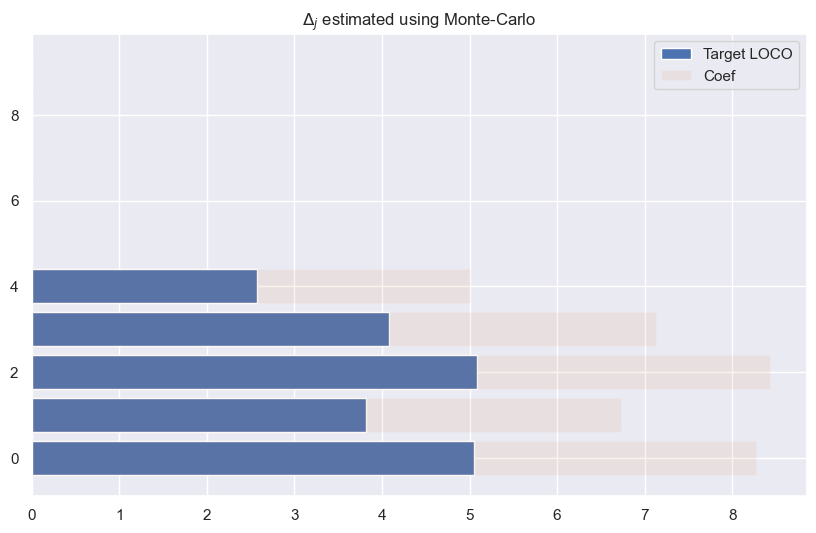

In [235]:
plt.barh([i for i in range(10)], np.mean(Delta, axis=0))
plt.barh([i for i in range(10)], beta0, alpha=0.1)
plt.legend(['Target LOCO', 'Coef'])
plt.title('$\Delta_{j}$ estimated using Monte-Carlo')

In [189]:
def MC_Delta(X, y, model, n_iter=100):
    Delta = np.zeros(X.shape)
    for i in tqdm.tqdm(range(n_iter)):
        for j in range(X.shape[1]):
            ### Err(Y, mu_j(X_j))
            Xj = np.delete(X, j, axis=1)
            mu_j = get_LOO_predictions(Xj, y, model)
            err_j = np.abs(y - mu_j)
            
            ### Err(Y, mu(X))
            mu = get_LOO_predictions(X, y, model)
            err = np.abs( y - mu)
            
            Delta[:,j] += err_j - err
    return Delta/n_iter

In [204]:
# Delta = MC_Delta(X,y, model)

In [202]:
np.mean(Delta, axis=1)

array([-2.98404753, -3.53422971, -3.1121477 , -3.38745385, -3.76474591,
       -4.37248791, -4.49121665, -4.55647546, -4.38204596, -4.54094105])

<BarContainer object of 10 artists>

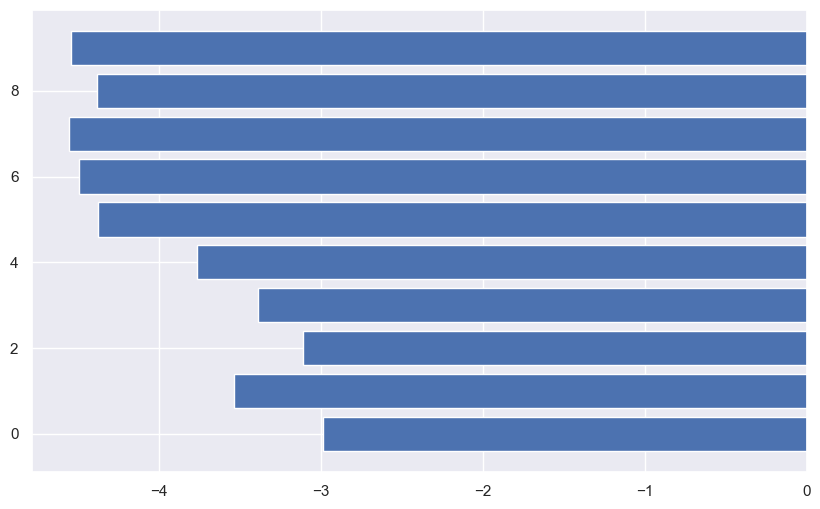

In [203]:
plt.barh([i for i in range(M)], np.mean(Delta, axis=1))

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


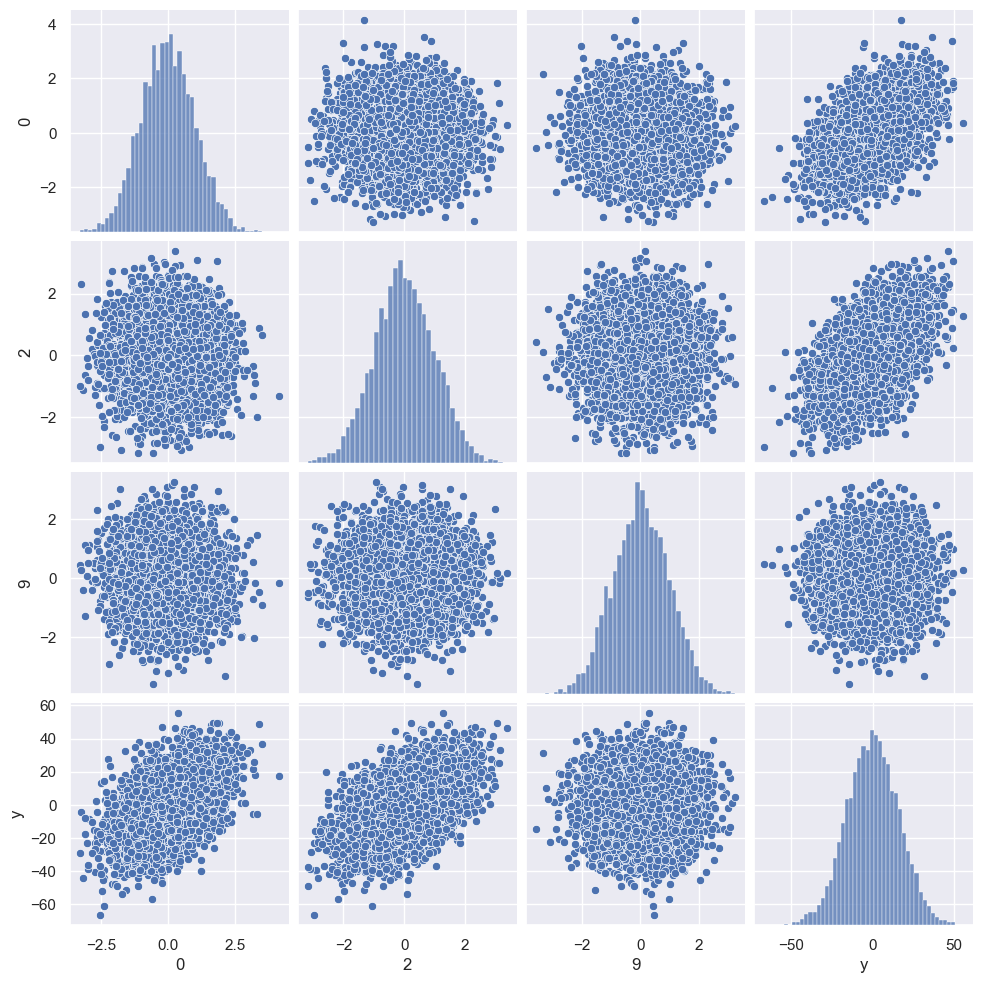

In [134]:
sns.set_theme(rc={'figure.figsize':(10,6)})
data = pd.DataFrame(X)
data['y'] = y
sns.pairplot(data.iloc[:,[0,2, 9, 10]])

In [6]:
beta

array([8.26967282, 6.73253801, 8.42935968, 7.12859569, 5.0087833 ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

<BarContainer object of 10 artists>

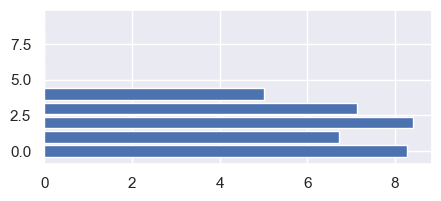

In [7]:
plt.figure(figsize=(5,2))
plt.barh([i for i in range(M)], beta)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [9]:
def mp_shapley(Xi, res):
    new_shap = np.zeros((Xi.shape))
    for i in range(Xi.shape[1]): 
        new_shap[:,i] = shapley_mp(i, res)
    return new_shap


In [16]:
model = Lasso()
x_ratio = 0.2
B = 100

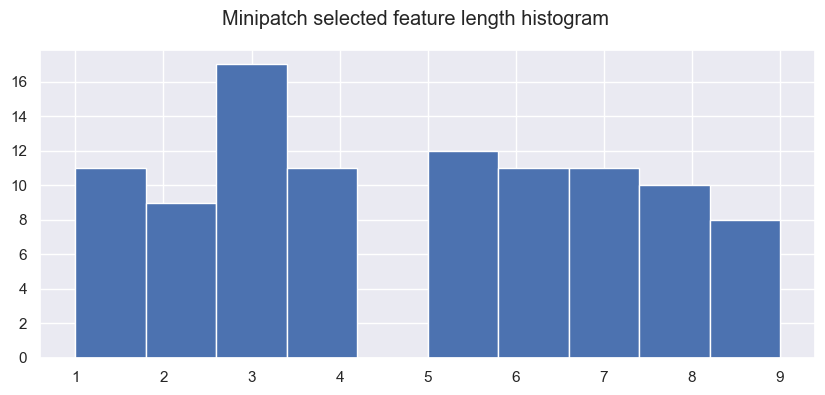

In [17]:
res = minipatch_regression(X_train, y_train, X_test, model, x_ratio, B, plot_prop = True)
shapmp = mp_shapley(X_test, res)

NameError: name 'plt' is not defined

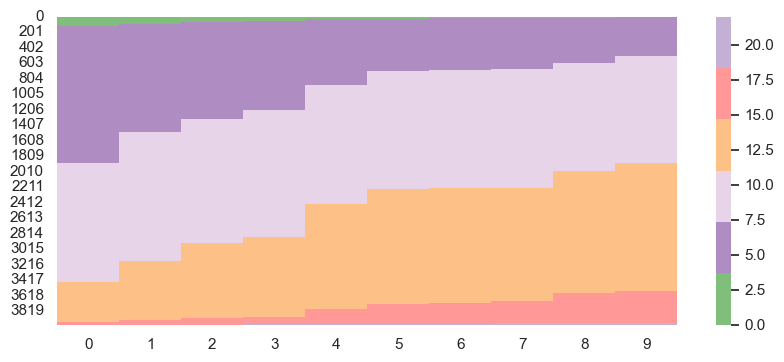

In [26]:
visualise_minipatch(res[1], res[2])

NameError: name 'shap_values_v' is not defined

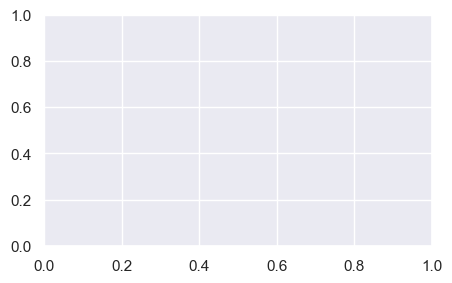

In [20]:
import shap
# model = Lasso()
model.fit(X, y)
predictions = model.predict(X)

plt.subplots(figsize=(5,3))
plt.barh([i for i in range(M)], np.abs(np.mean(shap_values_v, axis=0)))
plt.title('Shapley values with $v(S) = |y - f_S (x_S)|$')

In [416]:
y_test.shape

(1000,)

In [408]:
target_feature = 2

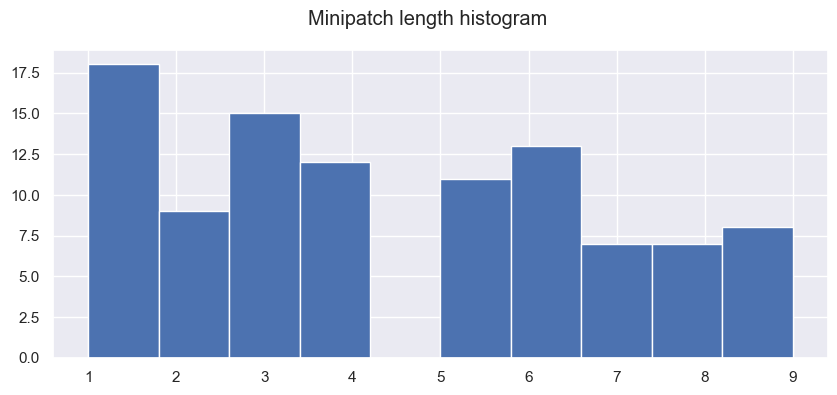

In [435]:
from scipy.special import binom
res =  minipatch_regression(X_train, y_train, X_test, model, x_ratio, 100, plot_prop = True)


In [427]:
shapley_j

-0.9191442484341823

In [31]:
from scipy.special import binom
def shapley_mp_Delta(target_feature, y_test, res):
    pred, in_mp_obs, in_mp_feature = res
    pred = np.array(pred)
    n = np.sum(in_mp_obs, axis=1)[0]
    all_features = np.unique(in_mp_feature,axis=0) # get all features sampled in MPs
    # all_features is now one-hot encoding of the positions 
    features_target = all_features[np.where(all_features[:,target_feature]==False)] # ohe for the feature subsets that exclude target feature
    dk = features_target.shape[0]
    d = all_features.shape[0]
    
    diff = []
    for row in features_target:
        val_diff = 0 
        row_j = row.copy()
        row_j[target_feature] = True
    
        # get in in_mp_feature the corresponding elements 
        mask = np.all(in_mp_feature == row, axis=1)
        mask_j =  np.all(in_mp_feature == row_j, axis=1)
        if in_mp_feature[mask_j].shape[0] == 0:
            mu_j = np.abs(y_test- np.zeros(1))
            mu_k = np.abs(y_test-np.zeros(1))
        else:
            mu_k = np.abs(y_test - np.mean(pred[mask,:,0],axis=0))
            mu_j =np.abs( y_test - np.mean(pred[mask_j,:,0], axis=0))
        val_diff = mu_j - mu_k
        # print(binom(d-1,sum(row)))
        diff.append(1/binom(d-1,sum(row)) * val_diff)
    shapley_j = 1/d* np.sum(diff)
    return shapley_j

In [32]:
def mp_shapley_Delta(Xi, yi, res):
    new_shap = np.zeros((Xi.shape[1]))
    for i in range(Xi.shape[1]): 
        new_shap[i] = shapley_mp_Delta(i, yi, res)
    return new_shap


In [33]:
mp_values_Delta  = mp_shapley_Delta(X_test, y_test, res)

<BarContainer object of 10 artists>

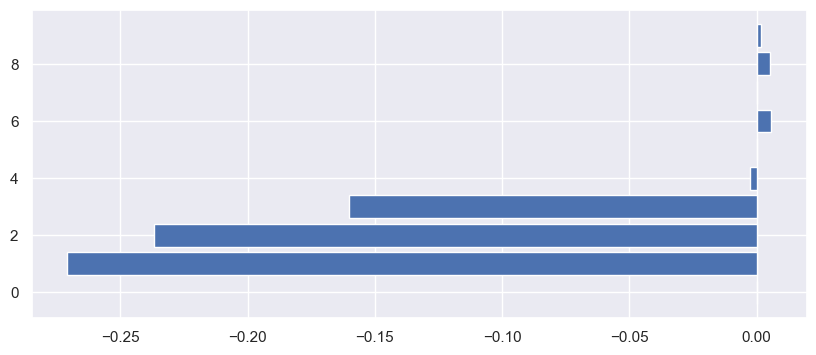

In [34]:
plt.barh([i for i in range(M)], mp_values_Delta)

In [259]:
def plot_CI(a, b, c, ax, color):
    for i in range(len(a)):
        ax.plot([a[i], c[i]], [i, i], color=color)  # Plot a line segment between (a[i], i) and (c[i], i)
        ax.scatter([a[i], c[i]], [i, i], marker='|', color=color)  # Plot markers at (a[i], i), (b[i], i), and (c[i], i)
        ax.scatter(b[i], [i], marker='o', color=color)
    ax.set_yticks(np.arange(len(a)), ['feature_{}'.format(i) for i in range(len(a))])  # Set y-axis ticks

    # plt.ylabel('Feature importance score')
    ax.set_title('Feature importance $\Delta_j$ with confidence interval')
    ax.barh(['feature_{}'.format(i) for i in range(M)], b, color=color, alpha=0.2, label='LOCOMP')
    ax.grid(True)


100%|██████████| 3/3 [00:18<00:00,  6.03s/it]


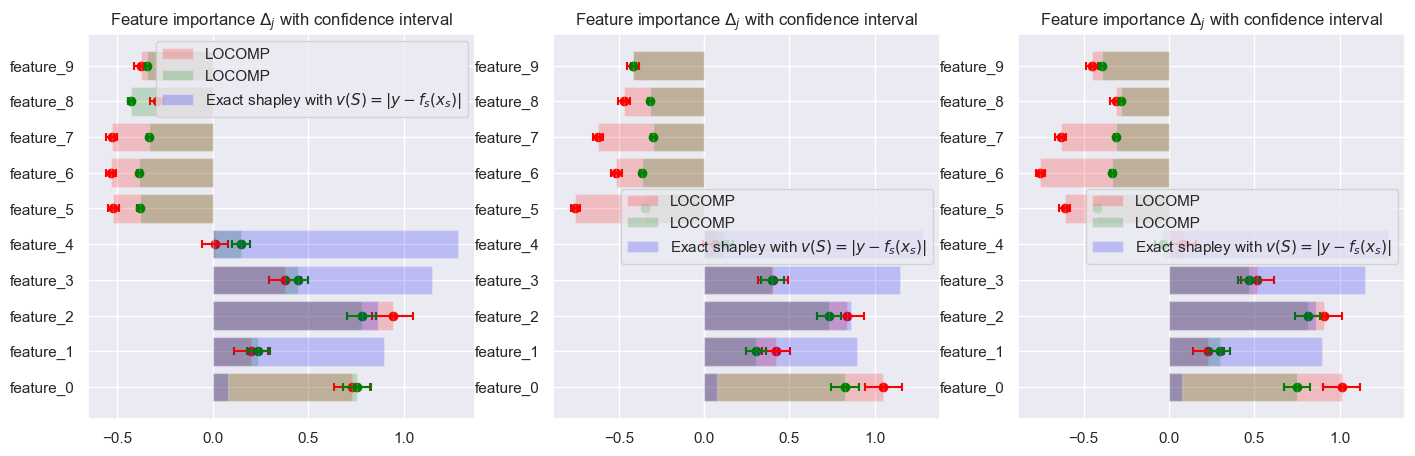

In [401]:
B = 500
fig, ax = plt.subplots(1,3, figsize=(17,5))
list_x = [0.2, 0.4, 0.6]
for i in tqdm.tqdm(range(3)):
    res_random = LOCOMP_random(X,y,list_x[i],B,model, selected_features=[],alpha=0.1,bonf=True)
    res = LOCOMPReg(X,y,list_x[i], m_ratio,B,model, selected_features=[],alpha=0.1,bonf=True)
    left = res['loco_ci'][:,2]
    right = res['loco_ci'][:, 3]
    delta = res['info'].groupby('j').mean().zz 
    left_r = res_random['loco_ci'][:,2] - res_random['info'].mean().zz 
    right_r = res_random['loco_ci'][:, 3]  - res_random['info'].mean().zz 
    delta_r = res_random['info'].groupby('j').mean().zz - res_random['info'].mean().zz 
    plot_CI(left_r, delta_r, right_r, ax[i], 'red')
    plot_CI(left, delta, right, ax[i], 'green')
    ax[i].barh(['feature_{}'.format(i) for i in range(M)],np.abs(np.mean(shap_values_v,axis=0)), color='blue', alpha=0.2, label='Exact shapley with $v(S) = |y-f_s(x_s)|$')
ax[0].legend()
plt.suptitle('Comparison with B = {}'.format(B))
fig.savefig('./figures/NLM_Lasso_feature_plot_CI.svg')

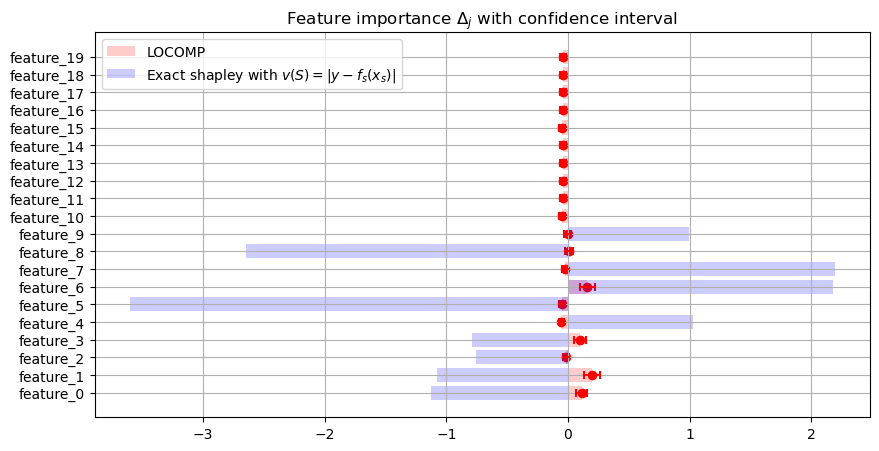

In [228]:
fig, ax = plt.subplots(figsize=(10,5))
left = res_random['loco_ci'][:,2] - res_random['info'].mean().zz 
right = res_random['loco_ci'][:, 3] - res_random['info'].mean().zz 
delta = res_random['info'].groupby('j').mean().zz - res_random['info'].mean().zz 
plot_CI(left, delta, right, ax,'red')
ax.barh(['feature_{}'.format(i) for i in range(M)],np.mean(shap_values_v,axis=0), color='blue', alpha=0.2, label='Exact shapley with $v(S) = |y-f_s(x_s)|$')
ax.legend()
plt.savefig('./figures/NLM_Lasso_feature_plot_CI_random_patches.svg')

100%|██████████| 1000/1000 [00:08<00:00, 119.06it/s]


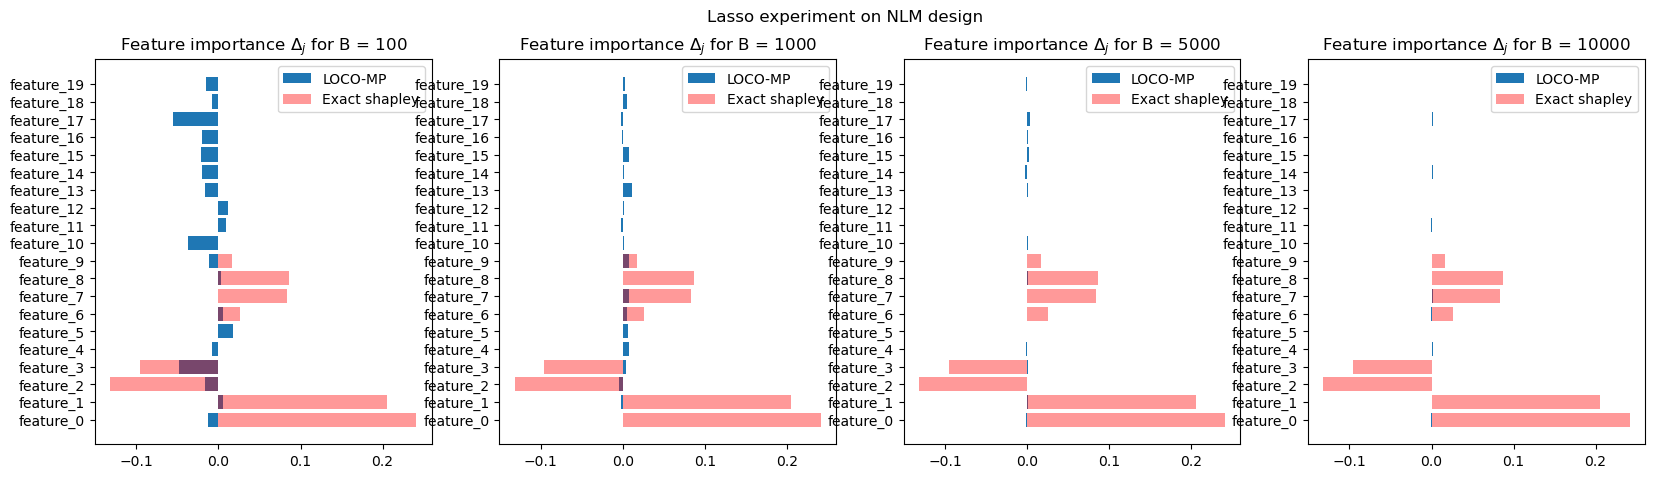

In [46]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    Delta = loco_error(X,y, model, x_ratio,list_B[b])
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(Delta, axis=0))
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.suptitle('Lasso experiment on NLM design')
plt.savefig('./figures/NLM_mine_locomp_Lasso_SNR{}.svg'.format(SNR))

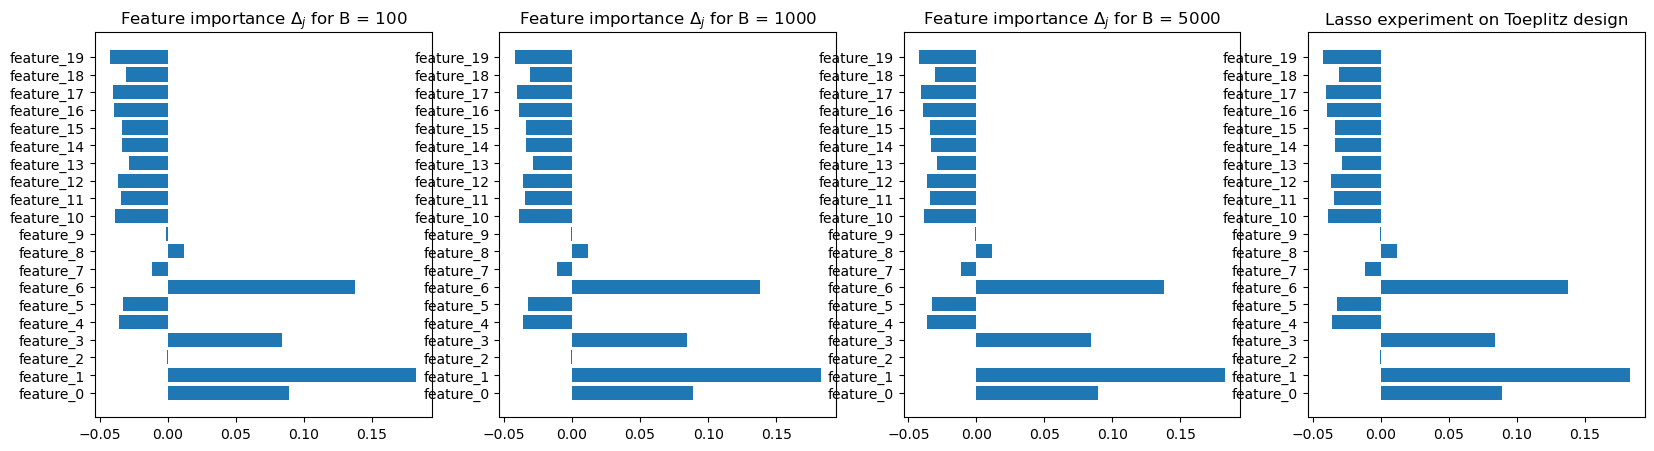

In [104]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res_random = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_locomp_Lasso_SNR{}.svg'.format(SNR))

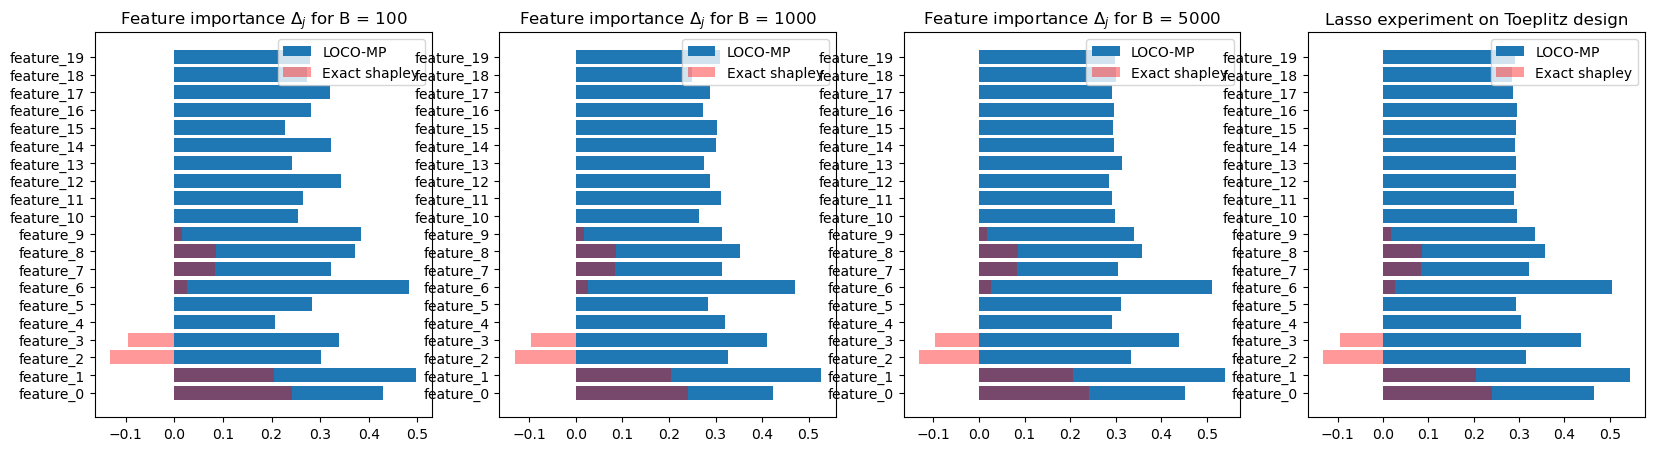

In [55]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.5
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_locomp_Lasso_SNR{}.svg'.format(SNR))

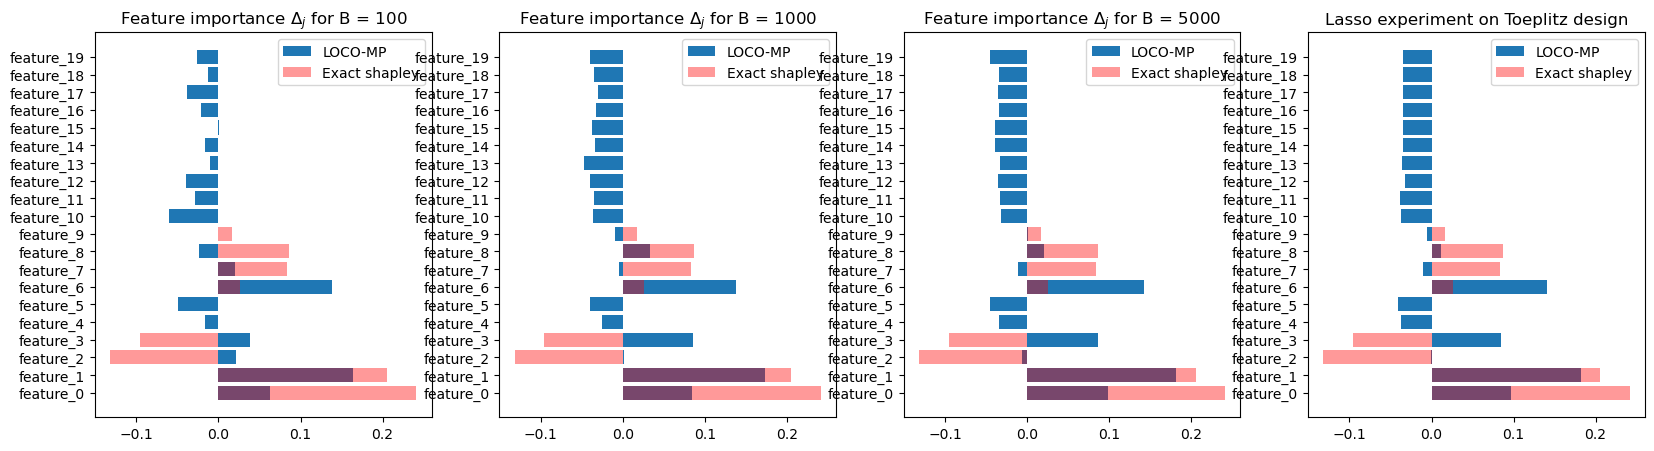

In [47]:
list_B = [100, 1000, 5000, 10000]
n_ratio = 0.2
m_ratio = 0.3
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMPReg(X,y,n_ratio, m_ratio,list_B[b], model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_og_locomp_Lasso_SNR{}.svg'.format(SNR))

## Toeplitz design

In [35]:
M = 10 # features
N = 5000 # observations
rho = 0.8
s = 0.5
SNR = 10
y, X, beta = correlated_features_regression(N, M, s=s, SNR=SNR, type='toeplitz') #toeplitz or equi-corr

In [36]:
beta

array([8.26967282, 6.73253801, 8.42935968, 7.12859569, 5.0087833 ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [37]:
data = pd.DataFrame(X)
data['y'] = y

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


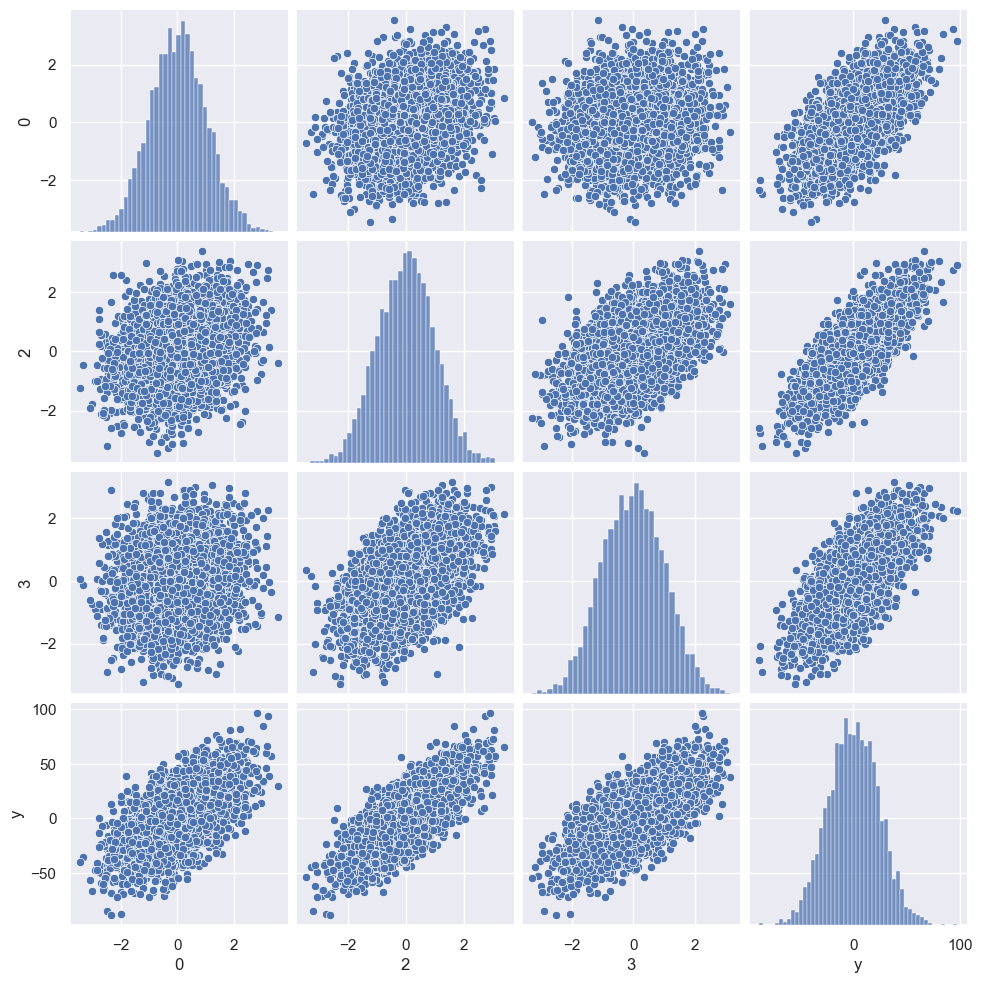

In [40]:
sns.pairplot(data.iloc[:,[0,2, 3, 10]])

<BarContainer object of 10 artists>

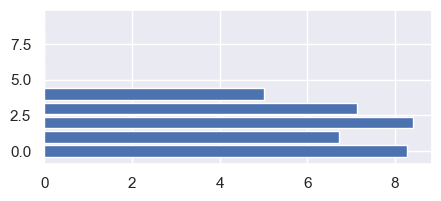

In [41]:
plt.figure(figsize=(5,2))
plt.barh([i for i in range(M)], beta)

<BarContainer object of 10 artists>

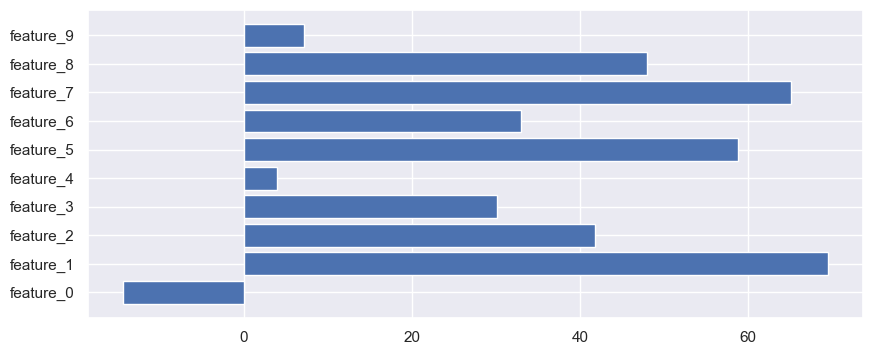

In [46]:
plt.barh(['feature_{}'.format(i) for i in range(M)], np.sum(Delta, axis=0))

100%|██████████| 5000/5000 [04:16<00:00, 19.52it/s]


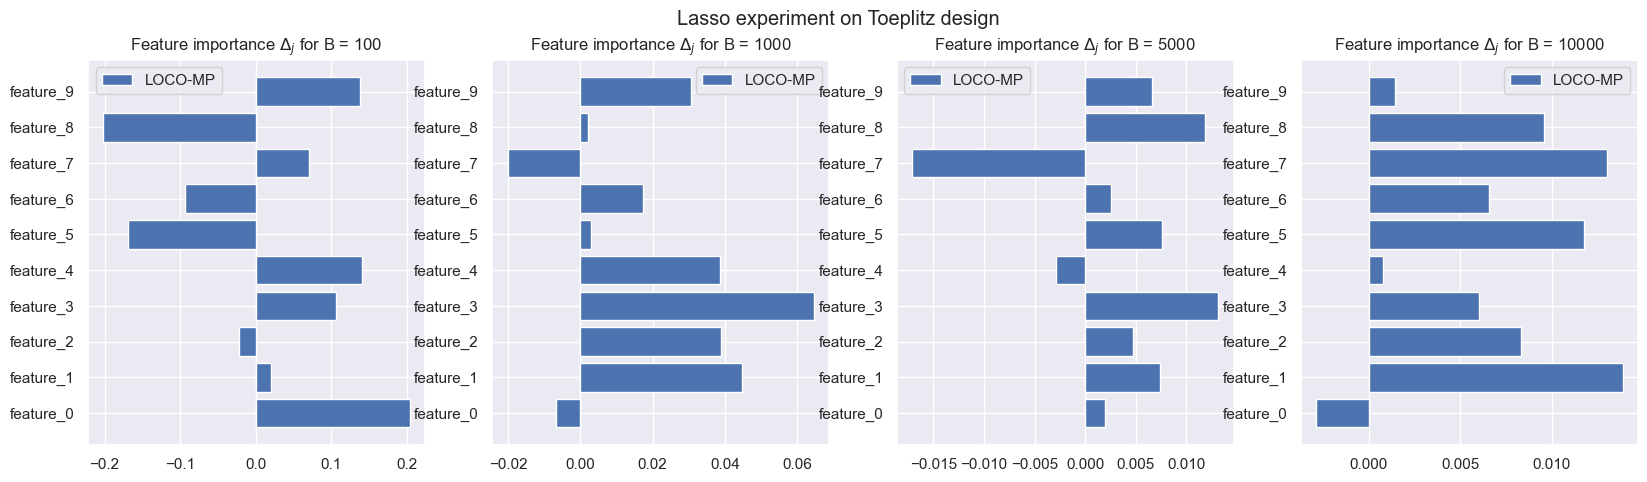

In [43]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    Delta = loco_error(X,y, model, x_ratio,list_B[b])
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(Delta, axis=0))
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    # ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.suptitle('Lasso experiment on Toeplitz design')
plt.savefig('./figures/mine_locomp_Lasso_SNR{}.svg'.format(SNR))

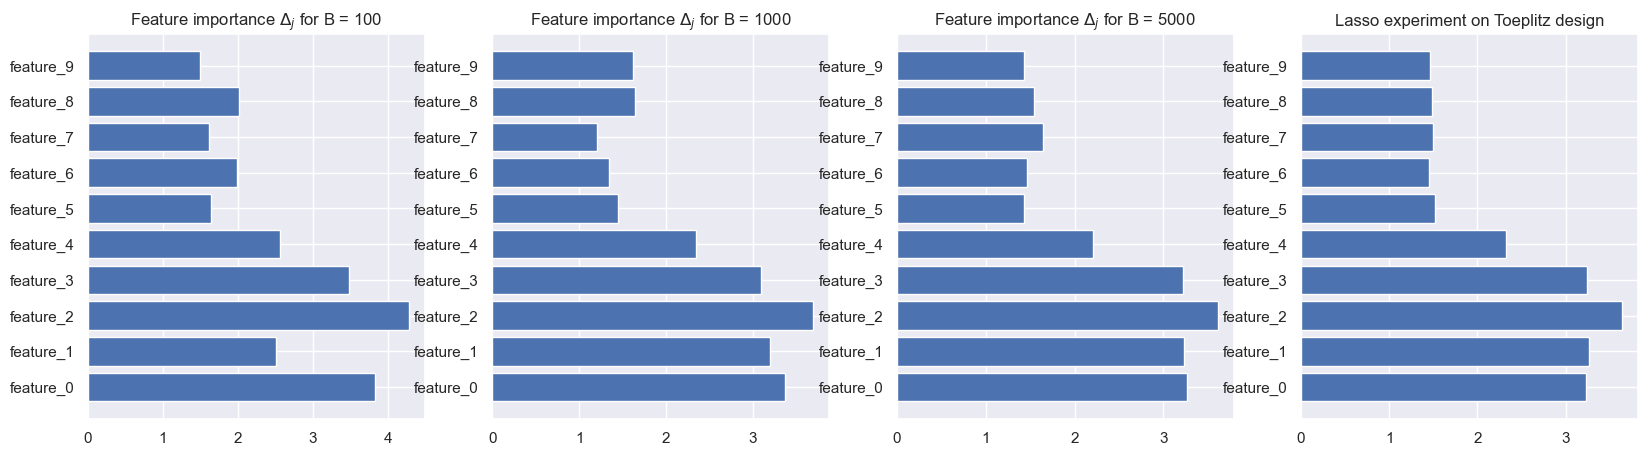

In [44]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/locomp_Lasso_SNR{}.svg'.format(SNR))

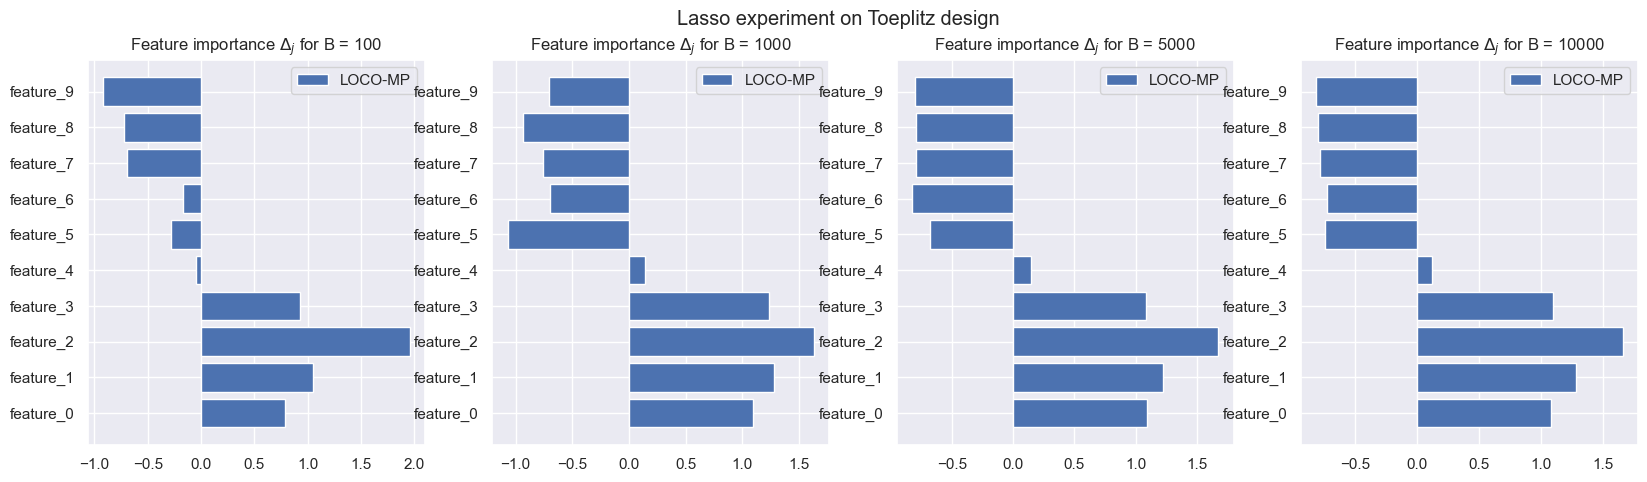

In [45]:
list_B = [100, 1000, 5000, 10000]
n_ratio = 0.2
m_ratio = 0.3
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMPReg(X,y,n_ratio, m_ratio,list_B[b], model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    # ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.suptitle('Lasso experiment on Toeplitz design')
plt.savefig('./figures/og_locomp_Lasso_SNR{}.svg'.format(SNR))

In [75]:
pred, in_mp_obs, in_mp_feature = minipatch_regression(X, y, X, model, x_ratio)
b_keep = pd.DataFrame(~in_mp_obs).apply(lambda i: np.array(i[i].index))

(array([   3.,   20.,  187.,  619., 1435., 1445.,  983.,  256.,   43.,
           9.]),
 array([746. , 756.5, 767. , 777.5, 788. , 798.5, 809. , 819.5, 830. ,
        840.5, 851. ]),
 <BarContainer object of 10 artists>)

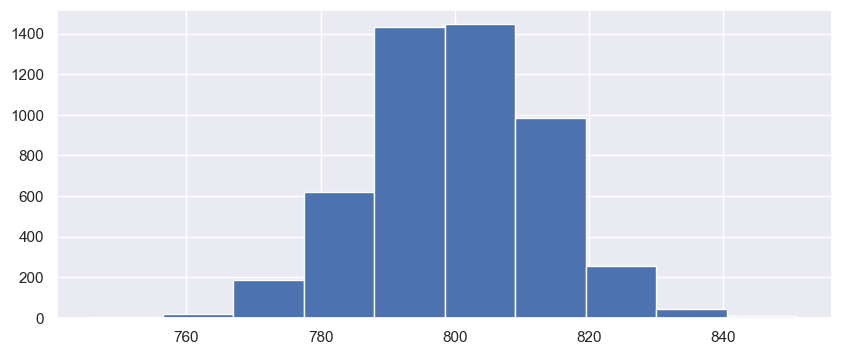

In [76]:
plt.hist([len(b_keep[i]) for i in range(len(b_keep))])

In [77]:
resids_LOO = list(map(lambda i: np.abs(y[i] - pred[b_keep[i],i].mean()),range(N)))

In [99]:
# get LOCO
pred_list = np.zeros((M,N))
for j in range(M):
    for i in range(N):
        b_keep_f = list(set(np.argwhere(~(in_mp_feature[:,j])).reshape(-1)) & set(np.argwhere(~(in_mp_obs[:,i])).reshape(-1)))
        pred_list[j][i] = pred[b_keep_f,i].mean()

5000